In [1]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent 
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

%load_ext autoreload
%autoreload 2

Added to path: /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6


In [2]:
import src.data.loader as loader
import src.modeling.pipeline as modeling_pipeline
import src.training.train_model as model_trainer
from scripts.constants import (
    CLEAN_DATA_DIR,
    Credit_Card_Data_Columns,
    CLEAN_CREDIT_CARD_DATA_FILE_NAME,
    Model_Names,
    LR_MODEL_FILEPATH,
    RF_MODEL_FILEPATH,
    XG_BOOST_FILEPATH,
)
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [3]:
data_loader = loader.DataLoader()

credit_card_df = data_loader.load_csv(
    file_name=CLEAN_CREDIT_CARD_DATA_FILE_NAME,
    file_path=CLEAN_DATA_DIR,
)

Loaded ../data/processed/credit_card_clean.csv to dataframe!


## Credit Card Data Modeling

In [4]:
credit_card_df.info()
print(tabulate(credit_card_df.tail(), headers="keys", tablefmt="grid"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283726 entries, 0 to 283725
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-null  float64
 20  V20     283726 non-null  float64
 21  V21     28

In [5]:
# Train Test Split
y = credit_card_df[Credit_Card_Data_Columns.CLASS.value]
X = credit_card_df.drop(columns=[Credit_Card_Data_Columns.CLASS.value])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [6]:
# Save the train/test splits
data_dir = Path("../data/credit_card_fraud")
data_dir.mkdir(parents=True, exist_ok=True)

X_train.to_csv(data_dir / "X_train.csv", index=False)
X_test.to_csv(data_dir / "X_test.csv", index=False)

y_train.to_csv(data_dir / "y_train.csv", index=False)
y_test.to_csv(data_dir / "y_test.csv", index=False)

print("Transaction Fraud train/test data saved.")

Transaction Fraud train/test data saved.


In [6]:
# Data Transformation
cols = [col.value for col in Credit_Card_Data_Columns]

data_transformer = modeling_pipeline.DataTransformer(custom_numeric_cols_checker=cols)
X_train_transformed = data_transformer.fit_transform(X_train)
X_test_transformed = data_transformer.transform(X_test)

In [7]:
# Handle Imbalance
imbalance_handler = modeling_pipeline.ImbalanceHandler()
X_train_bal, y_train_bal = imbalance_handler.fit_resample(X_train_transformed, y_train)

In [8]:
# Inspect Results
num_features = data_transformer.numeric_cols
feature_names = list(num_features) 

In [9]:
# Transformed Data
X_train_df = pd.DataFrame(
    X_train_transformed, columns=feature_names, index=X_train.index
)
print(
    tabulate(
        X_train_df[[Credit_Card_Data_Columns.AMOUNT.value]].head(), headers="keys", tablefmt="grid"
    )
)

+--------+-----------+
|        |    Amount |
+========+===========+
| 256381 | -0.3084   |
+--------+-----------+
| 118031 | -0.363961 |
+--------+-----------+
| 120210 |  1.8764   |
+--------+-----------+
| 162381 | -0.359922 |
+--------+-----------+
| 171306 | -0.344877 |
+--------+-----------+


In [10]:
print(y_train_bal.value_counts())

Class
0    198277
1     69396
Name: count, dtype: int64


Inspect Balanced Data:


<Axes: xlabel='Class', ylabel='count'>

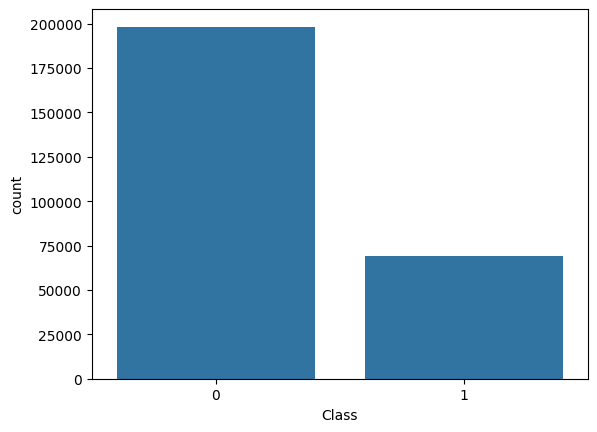

In [11]:
print("Inspect Balanced Data:")
sns.countplot(x=y_train_bal)

## Model Training & Cross-Validation

In [14]:
trainer = model_trainer.TrainModel(
    X_train=X_train_bal, X_test=X_test_transformed, y_train=y_train_bal, y_test=y_test, project_name="credit_card_fraud_detection"
)

### Train & Evaluate Baseline Logistic Regression Model

In [15]:
trainer.train_model(model_name=Model_Names.LOGISTIC_REGRESSION.value)
trainer.evaluate_model()
trainer.save_model(LR_MODEL_FILEPATH)

Training Logistic Regression...
Training Logistic Regression complete!
Metrics saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/metrics/Logistic Regression_metrics.json
Confusion matrix saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/figures/Logistic Regression_confusion_matrix.png
PR curve saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/figures/Logistic Regression_pr_curve.png
Confusion Matrix
: [[84301   675]
 [   23   119]]
F1-Score 0.25427350427350426
AUC-PR 0.6241833455856358
Model saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/models/credit_card_fraud_detection/logistic_regression.pkl


### Train & Evaluate Ensemble Random Forest Model with Hyperparameter Tuning

In [17]:
trainer.train_model(
    model_name=Model_Names.RANDOM_FOREST.value,
    class_weight="balanced",
    n_estimators=200,
    max_depth=20,
)
trainer.evaluate_model()
trainer.save_model(RF_MODEL_FILEPATH)

Training Random Forest...
Training Random Forest complete!
Metrics saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/metrics/Random Forest_metrics.json
Confusion matrix saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/figures/Random Forest_confusion_matrix.png
PR curve saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/figures/Random Forest_pr_curve.png
Confusion Matrix
: [[84954    22]
 [   33   109]]
F1-Score 0.7985347985347986
AUC-PR 0.7936121752067085
Model saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/models/credit_card_fraud_detection/random_forest.pkl


### Train & Evaluate Ensemble XGBoost Model with Hyperparameter Tuning

In [18]:
trainer.train_model(
    model_name=Model_Names.XGBoost.value,
    n_estimators=200,
    max_depth=7,
)
trainer.evaluate_model()
trainer.save_model(XG_BOOST_FILEPATH)

Training XGBoost...
Training XGBoost complete!
Metrics saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/metrics/XGBoost_metrics.json
Confusion matrix saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/figures/XGBoost_confusion_matrix.png
PR curve saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/figures/XGBoost_pr_curve.png
Confusion Matrix
: [[84956    20]
 [   34   108]]
F1-Score 0.8
AUC-PR 0.7773442929026884
Model saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/models/credit_card_fraud_detection/xg_boost.pkl


### Cross Validate Models and Compare Performance

In [19]:
# Only pass tree-specific params to tree models
tree_params = {"n_estimators": 200, "max_depth": 20}

results = []
for model_name in [
    Model_Names.LOGISTIC_REGRESSION.value,
    Model_Names.RANDOM_FOREST.value,
    Model_Names.XGBoost.value,
]:
    if model_name == Model_Names.LOGISTIC_REGRESSION.value:
        res = trainer.cross_val_evaluate(model_name=model_name)
    else:
        res = trainer.cross_val_evaluate(model_name=model_name, **tree_params)
    results.append(res)

Logistic Regression CV Results:
F1-Score: 0.914 ± 0.003
AUC-PR : 0.965 ± 0.002
Cross-validation metrics saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/metrics/Logistic Regression_cv_metrics.json
Random Forest CV Results:
F1-Score: 0.999 ± 0.000
AUC-PR : 1.000 ± 0.000
Cross-validation metrics saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/metrics/Random Forest_cv_metrics.json
XGBoost CV Results:
F1-Score: 1.000 ± 0.000
AUC-PR : 1.000 ± 0.000
Cross-validation metrics saved to /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/reports/credit_card_fraud_detection/metrics/XGBoost_cv_metrics.json


### Model Decision and Justification

#### Cross Validation Results Summary

| Model                  | CV F1    | CV AUC-PR | Stability             | 
|------------------------|----------|-----------|-----------------------|
| Logistic Regression    | ~0.91    | ~0.96     | Stable                |
| Random Forest          | ~0.999   | ~0.9999   | Extremley Stable      |
| XGBoost                | ~0.9996  | ~0.9999   | Extremley Stable      | 

#### Test Metrics Summary

| Model                  | Test F1    | Test AUC-PR |
|------------------------|----------|---------------|
| Logistic Regression    | 0.25     | 0.62          | 
| Random Forest          | 0.798    | 0.793         | 
| XGBoost                | 0.80     | 0.7773        | 


### Final decision for Credit Card Fraud

Best Model: Random Forest

**Why:**
- Higher test AUC-PR → better fraud ranking
- Lower false-positive rate → lower customer friction
- Comparable recall to XGBoost
- Easier SHAP interpretation than boosted trees

In a card-fraud context, excessive false positives directly translate to blocked cards, customer complaints, and churn. Random Forest offers a better operational balance.

**Important:**
XGBoost remains a strong challenger, but not the champion.